# The Bachelorette Predictor
### Kwame V. Taylor

The goal of this project is to create a machine learning model that accurately predicts how many weeks a contestant will last on the ABC reality show The Bachelorette, based on data from Seasons 1-2 and 4-12.

**Warning: This project contains *many* spoilers for past seasons.** Proceed at your own risk.

<img src="https://miro.medium.com/max/1280/1*S6OS8YFJWx0LT9wXNi0LkQ.png">

## Set up Environment

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import matplotlib as mpl

from cycler import cycler
import seaborn as sns

# default viz size settings
plt.rc('figure', figsize=(12, 8))
plt.rc('font', size=15)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

import warnings
warnings.filterwarnings("ignore")

In [2]:
from wrangle import acquire_data, join_dfs, drop_extra_cols
from preprocessing import handle_dates_and_elims, train_validate_test, parse_hometowns
from explore import make_heatmap, firstdate_swarmplot, swarmplot_by_season, pearsons_test
from model import model_1, model_2, model_3, model_4, model_1_test, model_4_test, evaluate_baseline

## Acquire & Prepare (Wrangle) the Data

Import raw datasets.

In [3]:
df, join = acquire_data()

In [4]:
df.head(3)

,Name,Age,Occupation,Hometown,ElimWeek,Season
0,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1
1,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1
2,Russ,30,Writer,"San Rafael, California",5.0,1


In [5]:
join.sort_values(by='SEASON').head(3)

,SEASON,CONTESTANT,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,ELIMINATION-5,ELIMINATION-6,ELIMINATION-7,ELIMINATION-8,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
281,1,01_WAYNE_X,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,1,01_RYAN_S,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
258,1,01_CHARLIE_M,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN


How to read the ```join``` DataFrame:

Feature         | Description
----------------|------------
`ELIMINATION-1` | Who was eliminated in week 1
`ELIMINATION-2` | Who was eliminated in week 2
`ELIMINATION-3` | Who was eliminated in week 3
`ELIMINATION-4` | Who was eliminated in week 4
`ELIMINATION-5` | Who was eliminated in week 5
`ELIMINATION-6` | Who was eliminated in week 6
`ELIMINATION-7` | Who was eliminated in week 7
`ELIMINATION-8` | Who was eliminated in week 8
`ELIMINATION-9` | Who was eliminated in week 9
`ELIMINATION-10`| Who was eliminated in week 10
`DATES-1`       | Who was on which date in week 1
`DATES-2`       | Who was on which date in week 2
`DATES-3`       | Who was on which date in week 3
`DATES-4`       | Who was on which date in week 4
`DATES-5`       | Who was on which date in week 5
`DATES-6`       | Who was on which date in week 6
`DATES-7`       | Who was on which date in week 7
`DATES-8`       | Who was on which date in week 8
`DATES-9`       | Who was on which date in week 9
`DATES-10`      | Who was on which date in week 10

- Eliminates connote either an elimination (starts with "E") or a rose (starts with "R").
- Eliminations supercede roses.
- "E" connotes a standard elimination, typically at a rose ceremony. "EQ" means the contestant quits. "EF" means the contestant was fired by production. "ED" connotes a date elimination. "EU" connotes an unscheduled elimination, one that takes place at a time outside of a date or rose ceremony.
- "R" means the contestant received a rose. "R1" means the contestant got a first impression rose.
- "D1" means a one-on-one date, "D2" means a 2-on-1, "D3" means a 3-on-1 group date, and so on.
- Weeks of the show are deliminated by rose ceremonies, and may not line up exactly with episodes.

Now I'll join the two dataframes.

In [6]:
df = join_dfs(df, join)

In [7]:
df.head(3)

,Name,Age,Occupation,Hometown,ElimWeek,Season,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
CONTESTANT,,,,,,,,,,,,,,,,,,,,,
1_RYAN_S,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_CHARLIE_M,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_RUSS_X,Russ,30,Writer,"San Rafael, California",5.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,NaN,NaN,NaN,NaN,NaN


In [8]:
df.head()

,Name,Age,Occupation,Hometown,ElimWeek,Season,ELIMINATION-1,ELIMINATION-2,ELIMINATION-3,ELIMINATION-4,...,DATES-1,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
CONTESTANT,,,,,,,,,,,,,,,,,,,,,
1_RYAN_S,Ryan Sutter,29,Firefighter,"Vail, Colorado",NaN,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_CHARLIE_M,Charlie Maher,28,Financial Analyst,"Hermosa Beach, California",6.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_RUSS_X,Russ,30,Writer,"San Rafael, California",5.0,1,NaN,NaN,NaN,NaN,...,NaN,D14,D1,D1,D1,NaN,NaN,NaN,NaN,NaN
1_GREG_T,Greg T.,28,Importer,"Manhattan, New York",4.0,1,NaN,NaN,NaN,E,...,NaN,D14,D5,D1,NaN,NaN,NaN,NaN,NaN,NaN
1_BOB_G,Bob Guiney,31,Mortgage Broker,"Ferndale, Michigan",3.0,1,NaN,NaN,E,NaN,...,NaN,D14,D5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Drop redundant features and unnecessary features for the project MVP (minimally viable product):
* ```ELIMINATION-1```
* ```ELIMINATION-2```
* ```ELIMINATION-3```
* ```ELIMINATION-4```
* ```ELIMINATION-5```
* ```ELIMINATION-6```
* ```ELIMINATION-7```
* ```ELIMINATION-8```
* ```ELIMINATION-9```
* ```ELIMINATION-10```
* ```Hometown```
* ```Occupation```
* ```Name```
* ```Season```
* ```DATES-1```

In [9]:
# drop columns
df = drop_extra_cols(df)

In [10]:
df.head(3)

,Age,Hometown,ElimWeek,Season,DATES-2,DATES-3,DATES-4,DATES-5,DATES-6,DATES-7,DATES-8,DATES-9,DATES-10
CONTESTANT,,,,,,,,,,,,,
1_RYAN_S,29,"Vail, Colorado",NaN,1,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_CHARLIE_M,28,"Hermosa Beach, California",6.0,1,D14,D1,D1,D1,D1,NaN,NaN,NaN,NaN
1_RUSS_X,30,"San Rafael, California",5.0,1,D14,D1,D1,D1,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check for null/NaN values
df.isna().sum()

Age           0
Hometown      0
ElimWeek      9
Season        0
DATES-2     109
DATES-3     135
DATES-4     159
DATES-5     174
DATES-6     198
DATES-7     215
DATES-8     232
DATES-9     244
DATES-10    253
dtype: int64

## Preprocessing

### Encoding, Imputing Nulls, and Feature Engineering with ```DATES``` and ```ELIMINATION```

* **NaNs in ```ElimWeek``` mean that that contestant won their season. I encoded this as 11.0**, representing that the contestants lasted until/past the end of their season (as Week 10 is the last week).
    * The choice to make winning contests have an ```ElimWeek``` of 11 may cause slightly lower One-on-One scores for winning contests because the dividing value (that I'm using to average the amount of One-on-One time per week) is ```ElimWeek```, yet there are no dates in the 11th week. I will compensate for this in a future iteration.
    * This calculation also does not account for seasons ending early/a contestant getting a win before Week 10. I will address this in a future iteration as well.


* **I dropped ```ELIMINATION``` features** because the presence of values there has a direct relationship with how many weeks a contestant lasts.
    * However, I may engineer features out of these columns, such as ```ReceivedFirstImpressionRose``` that don't have a direct correlation to how many weeks a contestant stays.


* **To quantify a constestant's ```OneonOneScore``` per week, each week's dates are represented by a float** that is equal to ```1``` divided by the ```number of people on the date``` per each date.
    * My reasoning behind this is that, anecdotally speaking, the fewer other people present on a date, the more that that date can affect the standing of a contestant on the date.
    * Therefore, the highest date value a contestant can have is if the value is 1, meaning they went on a date that week, and they went on that date as a One-on-One (a highly coveted type of date in the world of The Bachelorette).
    
* A contestant's **overall, or average, ```OneonOneScore```** for their entire time on the show is quantified by summing a contestant's weekly ```OneonOneScore```s and then dividing them by the number of weeks they were on the show.
    * The overall score will only be used in exploration, because it has a relationship with the target feature, ```ElimWeek```, as it is more likely for a contestant in get time with the bachelorette when there are, say, 9 people left on the show as opposed to 20.
    
* **I created ```FirstDate``` feature**.
    * This feature is a boolean that represents if a contestant was chosen to go on a date in the second week of their season, which is the week in which the first dates between the Bachelorette and the contestants occur.
 
 
* **I dropped unneeded columns** that were used to feature-engineer.
 
    
* I want to create a ```Homestate``` feature in a future iteration of this project.

In [12]:
df = handle_dates_and_elims(df)

In [13]:
# quick peek at the data, sorted by age to avoid seeing too much of one season
# and to make sure FirstDate is showing up correctly
df.sort_values(by='Age').head(3)

,Age,Hometown,ElimWeek,Season,Dates2-OneonOneScore,Dates3-OneonOneScore,One-on-One_Score,FirstDate
CONTESTANT,,,,,,,,
4_PAUL_B,23,"Bonnyville, Alberta",3.0,4,0.142857,0.1,0.060714,1.0
2_CORY_H,24,"Long Beach Island, New Jersey",1.0,2,0.000000,0.0,0.000000,0.0
1_MIKE_X,24,"Cincinnati, Ohio",3.0,1,0.071429,0.2,0.067857,1.0


In [14]:
df.isna().sum()

Age                     0
Hometown                0
ElimWeek                0
Season                  0
Dates2-OneonOneScore    0
Dates3-OneonOneScore    0
One-on-One_Score        0
FirstDate               0
dtype: int64

Now I'll take ```df.Hometown``` and engineer some useful features.

In [15]:
parse_hometowns(df)

,Age,ElimWeek,Season,Dates2-OneonOneScore,Dates3-OneonOneScore,One-on-One_Score,FirstDate,HomeRegion
CONTESTANT,,,,,,,,
1_RYAN_S,29,11.0,1,0.071429,1.0,0.339286,1.0,W
1_CHARLIE_M,28,6.0,1,0.071429,1.0,0.581633,1.0,W
1_RUSS_X,30,5.0,1,0.071429,1.0,0.511905,1.0,W
1_GREG_T,28,4.0,1,0.071429,0.2,0.254286,1.0,N
1_BOB_G,31,3.0,1,0.071429,0.2,0.067857,1.0,W
...,...,...,...,...,...,...,...,...
12_JAKE_P,26,1.0,12,0.000000,0.0,0.000000,0.0,W
12_JONATHAN_H,29,1.0,12,0.000000,0.0,0.000000,0.0,Other
12_NICK_S,26,1.0,12,0.000000,0.0,0.000000,0.0,W


Now I need to get dummies for HomeRegion to use it in modeling.

In [16]:
# Make dataframe for encoded columns

region_dummies = pd.get_dummies(df.HomeRegion, drop_first=True)
region_dummies.head(3)

,N,O,Other,S,W
CONTESTANT,,,,,
1_RYAN_S,0,0,0,0,1
1_CHARLIE_M,0,0,0,0,1
1_RUSS_X,0,0,0,0,1


* N - North East
* W - West
* M - Midwest
* S - South
* O - Other

Now join the dfs together and drop the features I don't need anymore.

In [17]:
# Now add encoded columns back onto original df and drop

df = pd.concat([df, region_dummies], axis=1)
df = df.drop(columns=['HomeRegion'])
df.head(3)

,Age,ElimWeek,Season,Dates2-OneonOneScore,Dates3-OneonOneScore,One-on-One_Score,FirstDate,N,O,Other,S,W
CONTESTANT,,,,,,,,,,,,
1_RYAN_S,29,11.0,1,0.071429,1.0,0.339286,1.0,0,0,0,0,1
1_CHARLIE_M,28,6.0,1,0.071429,1.0,0.581633,1.0,0,0,0,0,1
1_RUSS_X,30,5.0,1,0.071429,1.0,0.511905,1.0,0,0,0,0,1


### Train, validate, test splits

```ElimWeek``` is the feature we will be predicting on.

In [19]:
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = train_validate_test(df, 'ElimWeek')

Shape of train: (168, 11) | Shape of validate: (48, 11) | Shape of test: (48, 11)


In [20]:
X_train.head(3)

,Age,Season,Dates2-OneonOneScore,Dates3-OneonOneScore,One-on-One_Score,FirstDate,N,O,Other,S,W
CONTESTANT,,,,,,,,,,,
1_RYAN_S,29,1,0.071429,1.0,0.339286,1.0,0,0,0,0,1
1_CHARLIE_M,28,1,0.071429,1.0,0.581633,1.0,0,0,0,0,1
1_RUSS_X,30,1,0.071429,1.0,0.511905,1.0,0,0,0,0,1


In [21]:
y_train.head(3)

CONTESTANT
1_RYAN_S       11.0
1_CHARLIE_M     6.0
1_RUSS_X        5.0
Name: ElimWeek, dtype: float64

### Scale the data

I'll scale the data on my next iteration through the data science pipeline.

## Exploratory Data Analysis

### Which contestants last more weeks, by season and age?

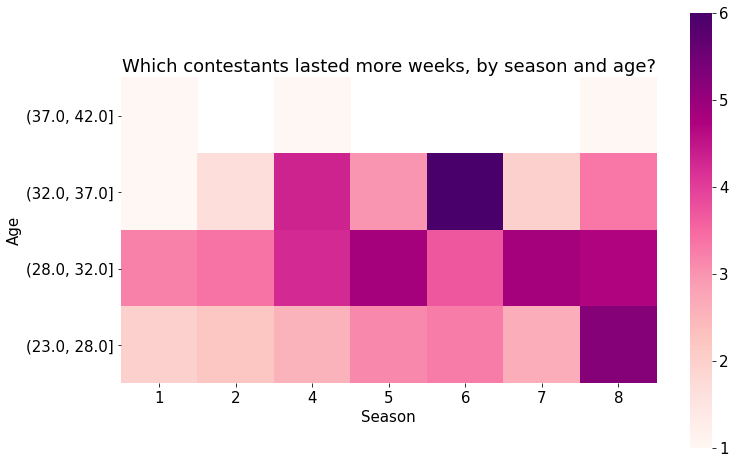

In [22]:
make_heatmap(train)

Beginning with the first season of The Bachelorette (which aired in 2003), it looks like the overall trend across seasons and time was increasingly favorsome towards younger contestants... That is, until Season 12 decided to invert that trend.

### Does getting one of the first dates in the season mean that a contestant will get more One-on-One time?

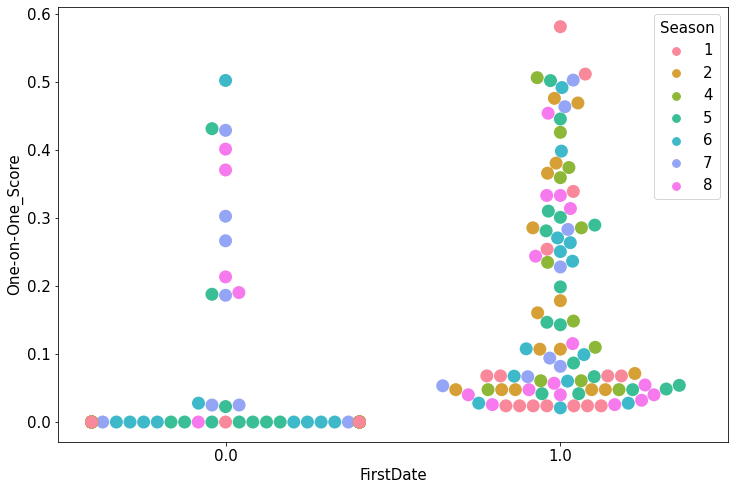

In [23]:
firstdate_swarmplot(train)

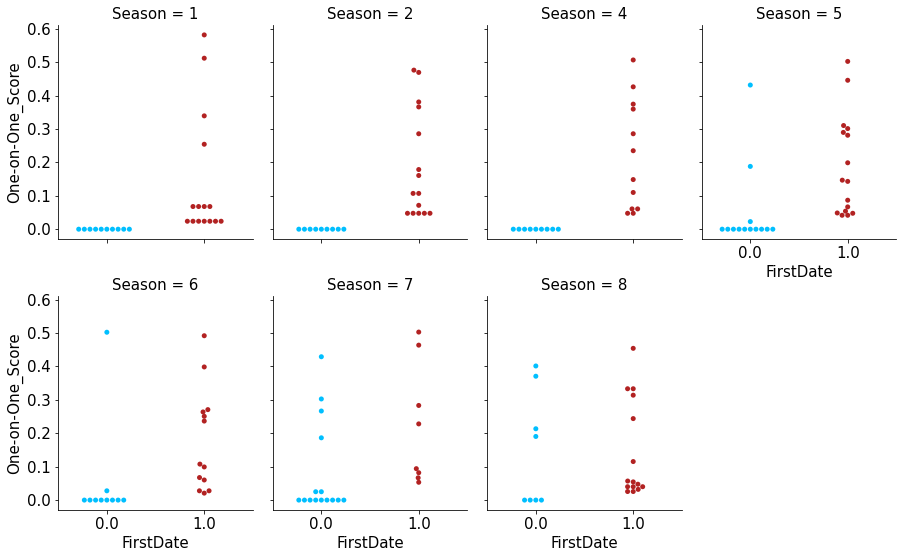

In [24]:
swarmplot_by_season(train)

For the most part, contestants that didn't get one of the first dates with the bachelorette didn't get nearly as much future date time as their counterparts who *did* go on one of the first dates.

In two seasons, however, the contestants who ended up getting the highest One-on-One scores actually did *not* get one of the first dates of their respective seasons.

Getting one of the First Dates does have a great effect on a contestant's future time with the bachelorette, but it's not necessarily a game-ender.

In fact, most of the contestants that went on to get any date time at all with the bachelorette -- after not going on a 'FirstDate' -- actually got more time than many of the other contestants who did go on a 'FirstDate'.

### Is there a linear relationship between One-on-One_Score and ElimWeek?

$
\begin{align*}
   H_0 & : \text{There is no linear correlation between a contestant's One-on-One Score and a contestant's Elimination Week.}
   \\
   H_a & : \text{There is a linear correlation between a contestant's One-on-One Score and a contestant's Elimination Week.}
   \\
    \alpha & : \text{0.05}
\end{align*}
$

In [25]:
alpha = 0.05
x = train['One-on-One_Score']
y = train.ElimWeek

In [26]:
pearsons_test(train, x, y, alpha)

r = 0.8377015803155536
p = 1.8111770699724813e-45


We reject the hypothesis that there is no linear correlation between a contestant's One-on-One Score and a contestant's Elimination Week.


## Predictive Modeling

# Can our model predict how long contestants will last on the show (in weeks), using data only from the first three episodes of a season?

**The goal is to produce a predictive model that outperforms the baseline in predicting the target value -- in this case, ```ElimWeek```.**

The train, validate, test splits:
```
Seasons 1 to 8 (66.67%) | Seasons 9 and 10 (16.667%) | Seasons 11 and 12 (16.667%)
```

I'm going to drop the overall/average One-on-One Score feature when modeling because it has too much of a relationship with the target variable. In the next iteration I will be updating my statistical testing and visualizations so that this is acknowledged.

> **Dec 6, 2020**
>
>I have decided to drop the One-on-One Score feature because it has too much relationship with the target variable. As the season progresses and there are fewer contestants left, it only follows that those contestants will get more relative one-on-one time than earlier in the season. Also, I want my predictor to be able to be used after the 3rd episode or before the 4th episode of a season, so that users (and myself) can use my model to predict the frontrunners of a season before the 4th episode of the show.
>
>Instead, I will keep the One-on-One scores for ```DATES-2``` and ```DATES-3```.

In [27]:
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = X_train.drop(columns=['One-on-One_Score']), y_train.drop(columns=['One-on-One_Score']), X_validate.drop(columns=['One-on-One_Score']), y_validate.drop(columns=['One-on-One_Score']), X_test.drop(columns=['One-on-One_Score']), y_test.drop(columns=['One-on-One_Score']), train.drop(columns=['One-on-One_Score']), validate.drop(columns=['One-on-One_Score']), test.drop(columns=['One-on-One_Score'])
X_train.head(2)

,Age,Season,Dates2-OneonOneScore,Dates3-OneonOneScore,FirstDate,N,O,Other,S,W
CONTESTANT,,,,,,,,,,
1_RYAN_S,29,1,0.071429,1.0,1.0,0,0,0,0,1
1_CHARLIE_M,28,1,0.071429,1.0,1.0,0,0,0,0,1


### Define and Evaluate Baseline

In [28]:
#np.median(y_train)
np.mean(y_train)

3.5357142857142856

In [29]:
#baseline = y_train.median()
baseline = y_train.mean()

evaluate_baseline(baseline, y_train, y_validate)

RMSE (Root Mean Square Error) of Baseline on train data:
 3.862457
RMSE (Root Mean Square Error) of Baseline on validate data:
 4.745429


Mean performed better than median. So, my baseline will be ```3.5357142857142856``` with a RMSE of ```3.862457``` on train.

### Model 1 - Ordinary Least Squares (OLS) using Linear Regression

In [30]:
# show available features
X_train.columns

Index(['Age', 'Season', 'Dates2-OneonOneScore', 'Dates3-OneonOneScore',
       'FirstDate', 'N', 'O', 'Other', 'S', 'W'],
      dtype='object')

In [31]:
# use all features except season
X = X_train.drop(columns=['Season'])
y = y_train

X_v = X_validate.drop(columns=['Season'])
y_v = y_validate

lm_pred, lm_rmse, lm_pred_v, lm_rmse_v = model_1(X, y, X_v, y_v)

RMSE for OLS using LinearRegression

On train data:
 2.62729 

 On validate data:
 3.349505


This model performs better than the baseline on both train and validate. 🎉

### Model 2 - Lasso & Lars

In [32]:
# use all features except season
X = X_train.drop(columns=['Season'])
y = y_train

X_v = X_validate.drop(columns=['Season'])
y_v = y_validate

pred_lars, rmse_train, pred_lars_v, rmse_validate = model_2(X, y, X_v, y_v)

RMSE for Lasso + Lars

On train data:
 3.862457 

 On validate data:
 4.745429


This model performs the same as baseline on both train and validate.

### Model 3 - Ordinary Least Squares (OLS) using Linear Regression

In [34]:
# use only FirstDate
X = X_train.drop(columns=['Age', 'Season', 'Dates2-OneonOneScore', 'Dates3-OneonOneScore',
       'N', 'O', 'Other', 'S', 'W'])
y = y_train

X_v = X_validate.drop(columns=['Age', 'Season', 'Dates2-OneonOneScore', 'Dates3-OneonOneScore',
       'N', 'O', 'Other', 'S', 'W'])
y_v = y_validate

lm_pred, lm_rmse, lm_pred_v, lm_rmse_v = model_3(X, y, X_v, y_v)

RMSE for OLS using LinearRegression

On train data:
 3.163032 

 On validate data:
 3.88854


Using only FirstDate as a feature yields pretty decent results and beats Model 2, however Model 1 still performs the best out of the three models.

### Model 4 - Random Forest

In [35]:
# use all features except season
X = X_train.drop(columns=['Season'])
y = y_train

X_v = X_validate.drop(columns=['Season'])
y_v = y_validate

forest_pred, forest_rmse, forest_pred_v, forest_rmse_v = model_4(X, y, X_v, y_v)

RMSE for RandomForestRegressor

On train data:
 0.378142 

 On validate data:
 2.250474


This model performs better than the baseline on both train and validate ***and*** it beats Model 1. 🎉🎉🎉

I wonder how well it would do with just data from the first **2** weeks of each season.

### Model 5 - Random Forest

In [36]:
# use all features except Season and Dates3-OneonOneScore
X = X_train.drop(columns=['Season', 'Dates3-OneonOneScore'])
y = y_train

X_v = X_validate.drop(columns=['Season', 'Dates3-OneonOneScore'])
y_v = y_validate

forest_pred, forest_rmse, forest_pred_v, forest_rmse_v = model_4(X, y, X_v, y_v)

RMSE for RandomForestRegressor

On train data:
 1.035959 

 On validate data:
 6.84056


Okay on train, but pretty terrible on validate.

**Now that I know Model 4 is the best performing, I will test it on the test data.**

In [38]:
# use all features except season

X = X_test.drop(columns=['Season'])
y = y_test

forest_pred, forest_rmse = model_4_test(X, y)

RMSE for RandomForestRegressor

On test data:
 0.548775


**Looks good!! Model 4 performs the best and beats the baseline.** 🥳

In [39]:
forest_pred

array([8.28      , 6.56      , 7.025     , 6.91      , 6.41      ,
       6.97      , 6.4       , 6.14      , 5.42      , 4.36      ,
       4.27      , 4.09      , 4.86      , 5.07      , 3.49      ,
       3.51      , 3.22      , 1.3       , 1.3       , 1.09      ,
       1.18      , 2.25      , 1.        , 8.42333333, 7.85      ,
       7.84      , 6.92      , 6.58      , 6.065     , 5.43      ,
       5.532     , 4.46      , 4.49133333, 4.52      , 4.336     ,
       5.08      , 4.49133333, 4.545     , 3.73      , 1.91      ,
       1.73      , 3.78166667, 1.09      , 1.11      , 1.        ,
       1.11      , 1.        , 1.        ])

## Conclusions

Go to sleep now. Stop coding... 😴😴😴😴😴😴😴😴

Tomorrow you will write conclusions (no more coding), and complete the project presentation via Canva.